# Extension : Figure 1A with Stack Overflow

## Libraries
- bq_helper : Api to simplify use of BigQuery Api, used to do queries and store result in a dataframe
- pandas : to perform operations on dataframes
- matplotlib : for plotting our values
- numpy : for list operations
- os : to set environmental variables

In [1]:
import bq_helper
from bq_helper import BigQueryHelper
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# Key to access to bigquery API, to change with own key if need to run in local
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="My Project 17425-755a3d361b77.json"

## Step 1 : Loading the data

The dataset we were using is a public dataset on the BigQuery application administered by Google. To access the dataset we use the Bq Helper API. As input we can give our SQL query to the database, and we have as output a dataframe containing the requested information.

In [2]:
# Initialization of the object allowing us to make queries to the BibQuery api
bq_assistant = BigQueryHelper("bigquery-public-data", "stackoverflow")

In [3]:
# SQL query to retrieve users
query_users = """SELECT
  id
FROM
  `bigquery-public-data.stackoverflow.users`
        """
# Call to load the result of the query in a dataframe.
df_users_1a = bq_assistant.query_to_pandas(query_users)

In [4]:
# SQL query to retrieve comments
query_comments = """SELECT
  id, user_id
FROM
  `bigquery-public-data.stackoverflow.comments`
        """
# Call to load the result of the query in a dataframe.
df_comments_1a = bq_assistant.query_to_pandas(query_comments)

In [5]:
df_users_1a

,id
0,671530
1,701253
2,774547
3,802093
4,908402
...,...
13036744,5453308
13036745,5662052
13036746,6064278
13036747,6206000


In [6]:
df_comments_1a

,id,user_id
0,112704172,13368658.0
1,112704180,9460412.0
2,112704181,11814875.0
3,112704184,13868755.0
4,112704196,13100478.0
...,...,...
76595431,2186136,267814.0
76595432,2186151,179328.0
76595433,2186185,77507.0
76595434,2186189,84201.0


## Step 2 : Filtering the data

We would like to create a plot showing the distribution of the number of comments according to users. To do this, each comment must be associated with a user, which is not the case in our dataframe containing the comments. We will therefore discard the comments associated with no user.


In [7]:
print('Number of comments before deleting those linked to no user : ',len(df_comments_1a))
df_comments_1a.dropna(inplace=True)
print('Number of comments after deleting those linked to no user : ',len(df_comments_1a))

Number of comments before deleting those linked to no user :  76595436
Number of comments after deleting those linked to no user :  75520794


## Step 3 : Processing and Plotting

Now that we have our data, we can process it to make our plot showind distribution of number of comments accross users. In the figure, the Complementary Cumulative Distributive Function (CCDF) of the number of comments per user is represented. 

Here are the different steps for the creation of our plot :

- Group by comments by user and count them
- Create a dataframe with all the users without any comments
- Add users of the platform who have not posted any comments to the dataframe with the count of comments per user
- Compute a list with as value the sum of accounts with a number of comments equal or superior to the position of the entry. eg - at position 2 have the number of users with at least 2 comments 
- Compute a list with the probability pr(X>=x) for each x, for the different minimum values of N. N is the minimum number of tweets for the users. We study the values of N ranging from 0 to 5 (included).
- Plot a scatterplot with the number of comments on the abscissa and the probability (CCDF) on the ordinate.

In [8]:
# Group by user and count, reset index is used to simplify operations on the dataframe
comments_count = df_comments_1a.groupby(by='user_id')['id'].count().reset_index()

In [9]:
# list of users id with 0 comments, constructed with the difference between the set of all users and the set with only the users with at leat one comment
users_0_comments_id = list(set(df_users_1a.id.values) - (set(comments_count.user_id.values)))

# Building the dataset with only users with 0 comments
df_users_0_comments = pd.DataFrame(list(zip(users_0_comments_id,[0]*len(users_0_comments_id))),columns=['user_id','id'])

# We add to the dataframe with the count of comments for users with at leat 1 comment all the users with 0 comments
df_allusers = comments_count.append(df_users_0_comments)

In [10]:
# The list with the number of occurrences is calculated using bincount function which counts the number of occurrences of each value in array of non-negative ints
occurences = np.bincount(df_allusers.id)

# Cumsum will contais the sum of accounts with a minimum number of tweets for different values.
cumsum = []

for i in range(0,len(occurences)):
    if (occurences[i]==0):
        cumsum.append(np.nan)
    else:
    # Cumsum takes the value of the sum of the elements between an index i and the end of the list occurrences if the number of occurrences of the value i is non-zero.    
        cumsum.append(occurences[i:].sum())

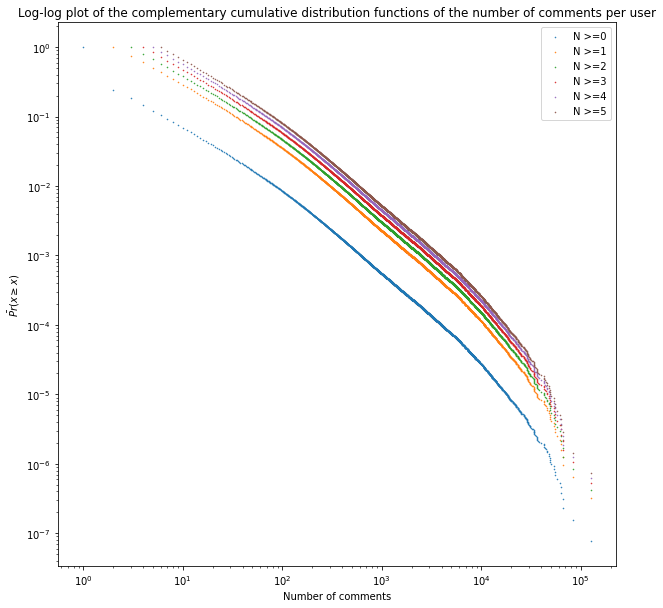

In [11]:
plt.figure(figsize=(10,10))

# We iterate over the different minimum values 
for n in range(0,6):
    
    # We retrieve the count of values greater than or equal to our minimum value - n -
    y = cumsum[n:]
    
    #To transform our values into probabilities, we divide our values by the sum of all occurrences
    y = y / y[0]
    

    statuses_values = df_allusers[df_allusers.id>=n].id.values.astype(int)
    
    # x is the list containing the possible values for the number of tweets. 
    # We add 1 to the min and max value, to have no 0, our scales are logarithmic, log(0) is undefined and therefore cannot be represented.
    x = range(min(statuses_values)+1, max(statuses_values)+2)
    
    # Size is set to .3 for clarity, and we choose 'o' as marker as in the figure we are trying to replicate
    plt.scatter(x,y,s=.3,label="N >="+str(n),marker='o')


# We give as parameters to our graph the same parameters as the figure for scale, titles and labels.
plt.legend()
plt.loglog()
plt.xlabel('Number of comments')
plt.ylabel(r'$\bar{Pr}(x \geq x)$')
plt.title('Log-log plot of the complementary cumulative distribution functions of the number of comments per user')

plt.show()